In [1]:
%matplotlib notebook
from physicellviewer import viewSimulation

Canvas(height=800, width=900)

RadioButtons(description='Mouse Action:', options=('move', 'zoom', 'select'), value='move')

IntSlider(value=0, continuous_update=False, description='Frame:', max=9)

RadioButtons(description='Generate Attribute Graph:\n', options=('ID', 'position.x', 'position.y', 'position.z…

SelectMultiple(description='Visible:', index=(0,), options=('cell', 'oxygen'), value=('cell',))

Output()

<IPython.core.display.Javascript object>


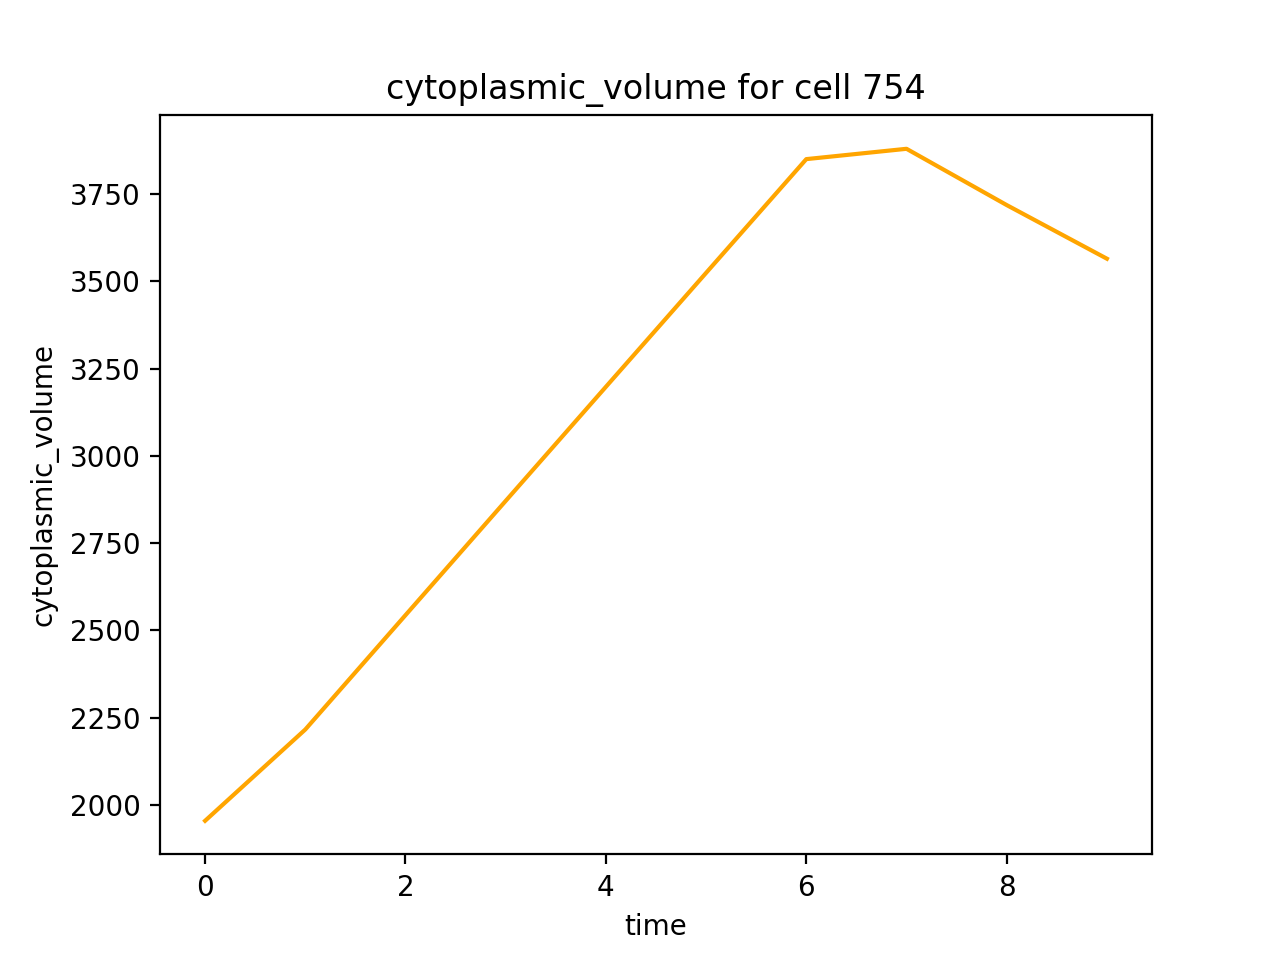

<IPython.core.display.Javascript object>


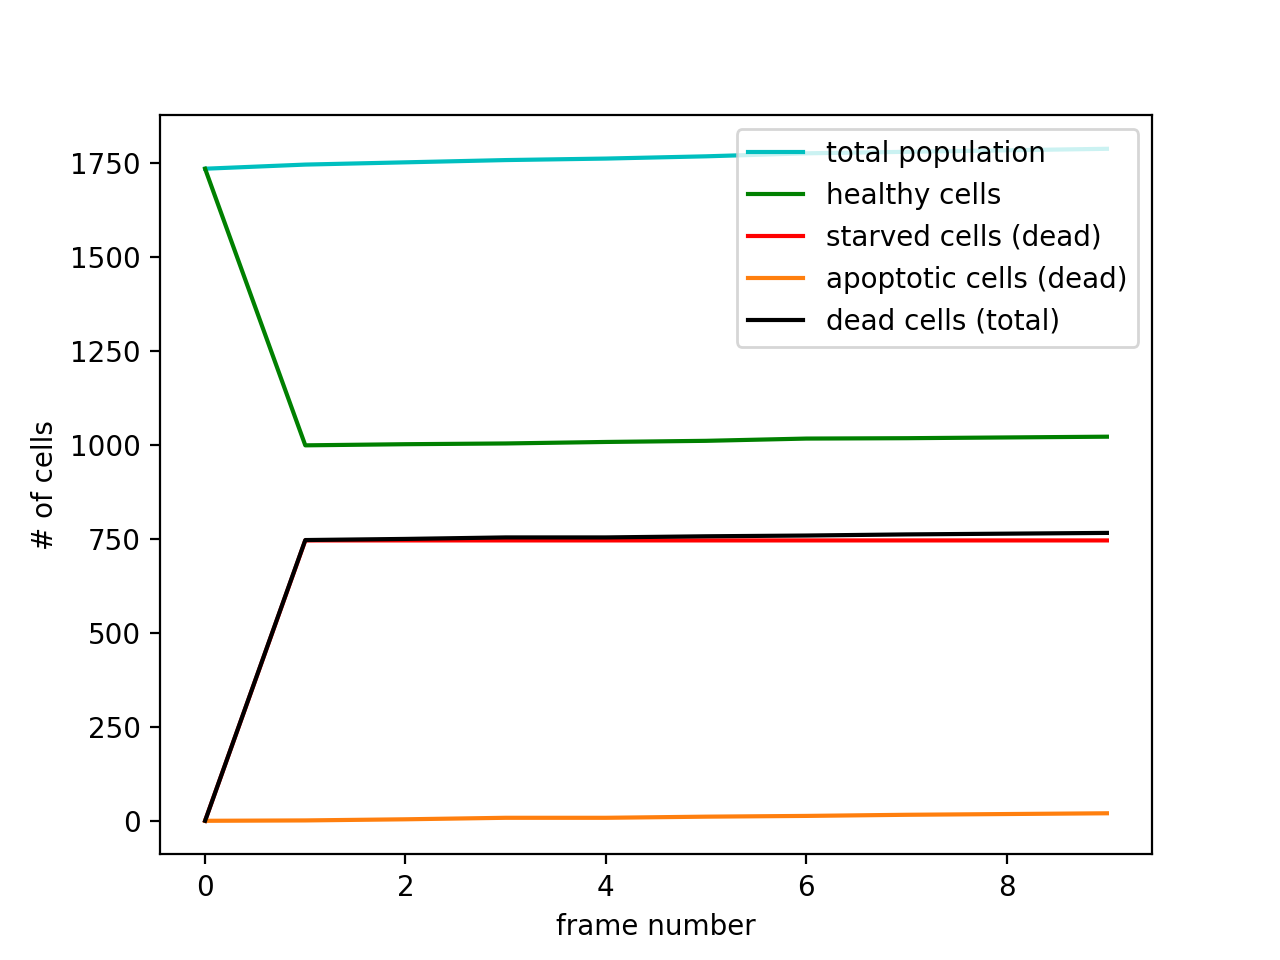

In [2]:
def filterFunction(cells, variables):
    return cells[variables['cycle_model']] == 5

env = viewSimulation('./sample-output', width=900, height=800)
env.show()

Canvas(height=800, width=800)

RadioButtons(description='Mouse Action:', options=('move', 'zoom', 'rotate', 'select'), value='move')

IntSlider(value=0, continuous_update=False, description='Frame:', max=5)

RadioButtons(description='Generate Attribute Graph:\n', options=('ID', 'position.x', 'position.y', 'position.z…

SelectMultiple(description='Visible:', index=(0,), options=('cell', 'oxygen', 'immunostimulatory factor'), val…

Output()

<IPython.core.display.Javascript object>


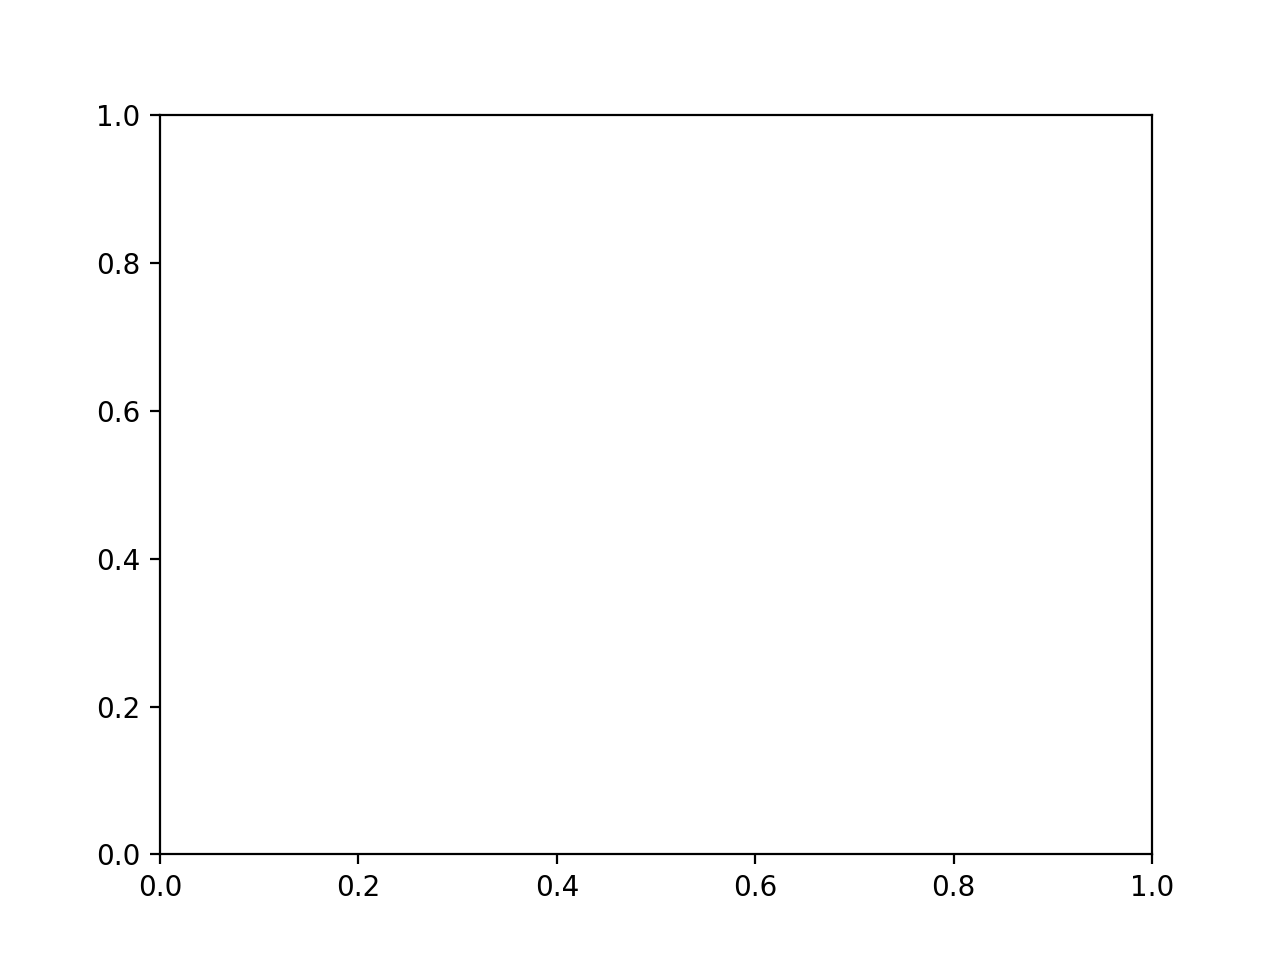

<IPython.core.display.Javascript object>


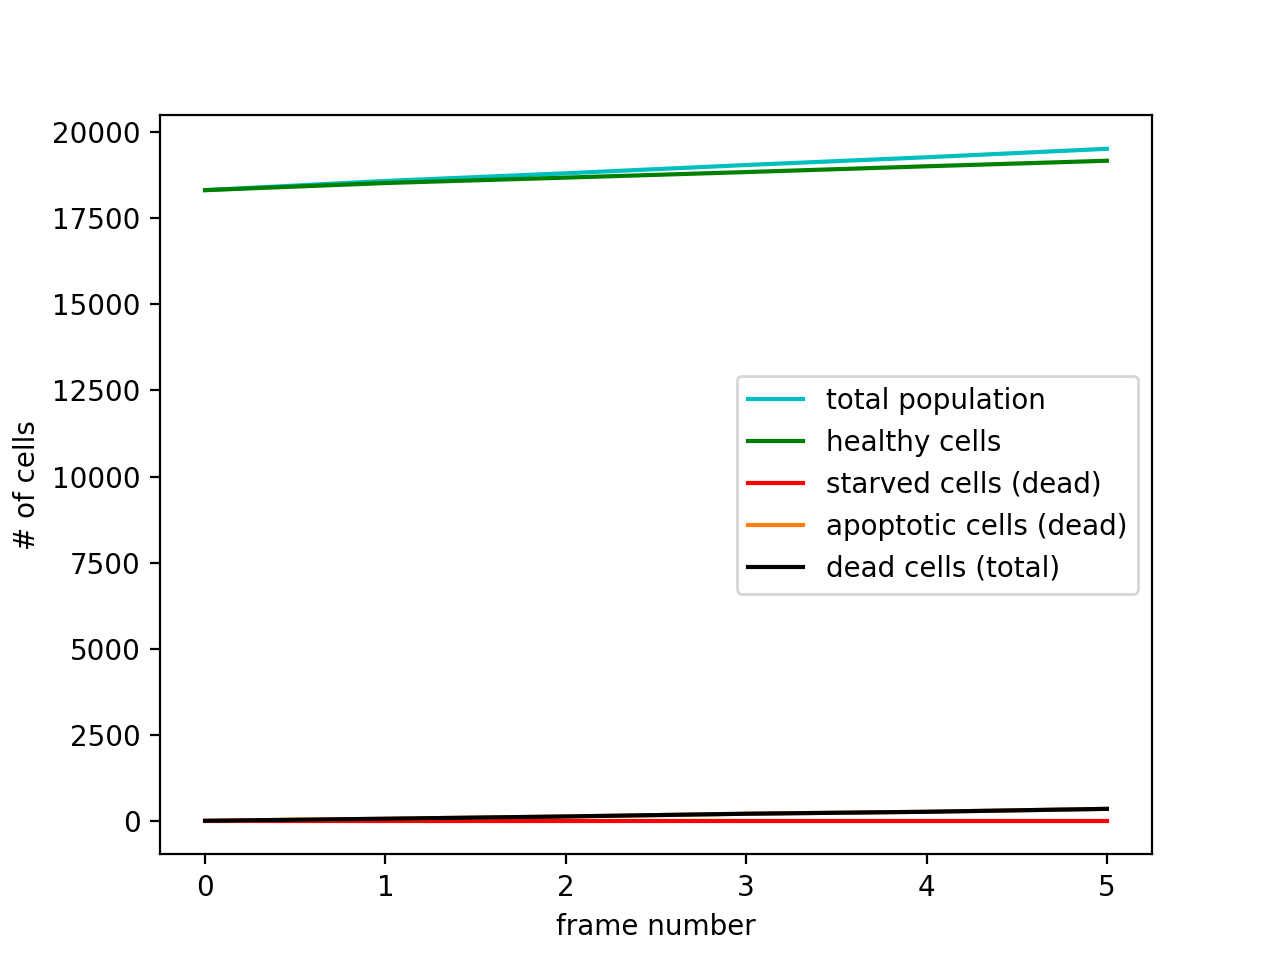

In [3]:
env = viewSimulation('./sample-output-3d', width=800, height=800)
env.show()

In [ ]:
from physicellviewer.filterFunctions import viewSimulation